In [20]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib import pyplot as plt

In [13]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
dataset_path = 'dataset3'  # Replace with your dataset path
img_height = 224
img_width = 224
batch_size = 32

In [ ]:
def prepare_data(dataset_path):
    # Create base directories
    base_dir = os.path.dirname(dataset_path)
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'validation')
    test_dir = os.path.join(base_dir, 'test')
    
    # Remove existing directories and recreate
    for dir_path in [train_dir, val_dir, test_dir]:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.makedirs(dir_path)
    
    # Get class names (folders in the dataset path)
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    
    # Split data for each class
    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        
        # Get all image files
        files = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
        
        # Shuffle files
        np.random.shuffle(files)
        
        # Calculate split indices
        total_files = len(files)
        train_split = int(0.7 * total_files)
        val_split = train_split + int(0.2 * total_files)
        
        # Create class-specific directories
        train_cls_dir = os.path.join(train_dir, cls)
        val_cls_dir = os.path.join(val_dir, cls)
        test_cls_dir = os.path.join(test_dir, cls)
        
        os.makedirs(train_cls_dir, exist_ok=True)
        os.makedirs(val_cls_dir, exist_ok=True)
        os.makedirs(test_cls_dir, exist_ok=True)
        
        # Copy files to respective directories
        for i, file in enumerate(files):
            src = os.path.join(cls_path, file)
            if i < train_split:
                dst = os.path.join(train_cls_dir, file)
            elif i < val_split:
                dst = os.path.join(val_cls_dir, file)
            else:
                dst = os.path.join(test_cls_dir, file)
            
            # Use copy instead of symlink
            shutil.copy2(src, dst)
    
    return train_dir, val_dir, test_dir

In [16]:
# Data augmentation and generators
def create_data_generators(train_dir, val_dir, test_dir):
    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    
    # Validation and test data generators (only rescaling)
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    return train_generator, val_generator, test_generator

In [17]:
# Build model
def build_model(num_classes):
    # Load pre-trained DenseNet121
    base_model = DenseNet121(
        weights='imagenet', 
        include_top=False, 
        input_shape=(img_height, img_width, 3)
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    
    return model

In [18]:
def train_model():
    # Prepare data
    train_dir, val_dir, test_dir = prepare_data(dataset_path)
    
    # Create data generators
    train_generator, val_generator, test_generator = create_data_generators(
        train_dir, val_dir, test_dir
    )
    
    # Get number of classes
    num_classes = len(train_generator.class_indices)
    print(f"Number of classes detected: {num_classes}")
    print(f"Class indices: {train_generator.class_indices}")
    
    # Build model
    model = build_model(num_classes)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    checkpoint = ModelCheckpoint(
        'best_densenet_model.keras', 
        save_best_only=True, 
        monitor='val_accuracy'
    )
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True
    )
    
    # Train model
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator,
        callbacks=[checkpoint, early_stopping]
    )
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
    
    # Save final model
    model.save('final_densenet_model.h5')
    
    return model, history

In [19]:
model, history = train_model()

Found 1421 images belonging to 2 classes.
Found 405 images belonging to 2 classes.
Found 206 images belonging to 2 classes.
Number of classes detected: 2
Class indices: {'fake': 0, 'real': 1}
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.5610 - loss: 0.6988 - val_accuracy: 0.6840 - val_loss: 0.5900
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7116 - loss: 0.5689 - val_accuracy: 0.7704 - val_loss: 0.5167
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.7323 - loss: 0.5267 - val_accuracy: 0.8148 - val_loss: 0.4559
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.8018 - loss: 0.4786 - val_accuracy: 0.8395 - val_loss: 0.4137
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8061 - loss: 0.4324 - val_accuracy: 0.8519 - val_loss: 0.3865
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8527 - loss: 0.3896 - val_accuracy: 0.8543 - val_loss: 0.3561
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - 

Test Accuracy: 88.35%


In [21]:
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

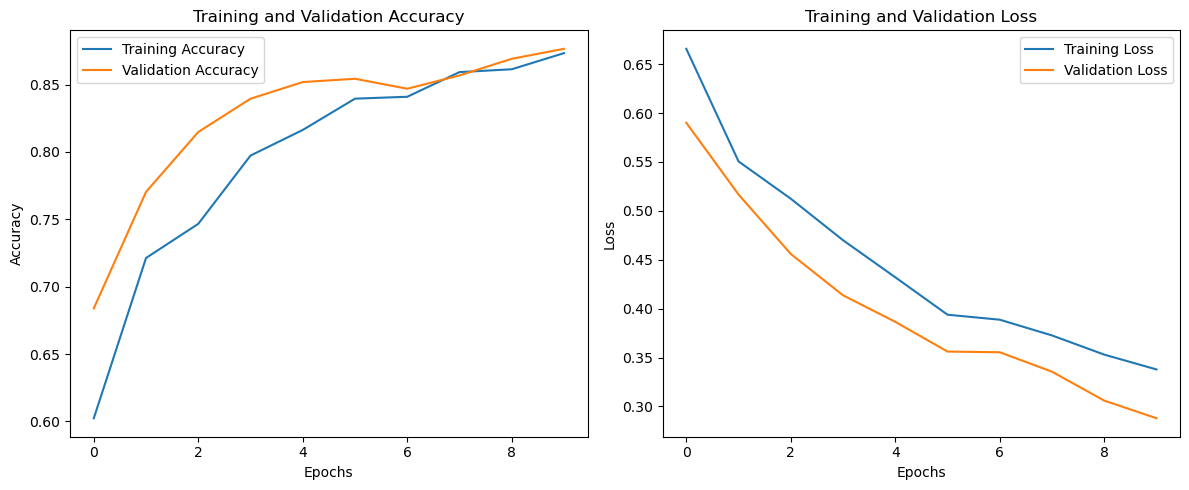

In [22]:
plot_training_history(history)